Davies-Bouldin Index: 1.4596861182324004
Silhouette Score: 0.17419950616481128


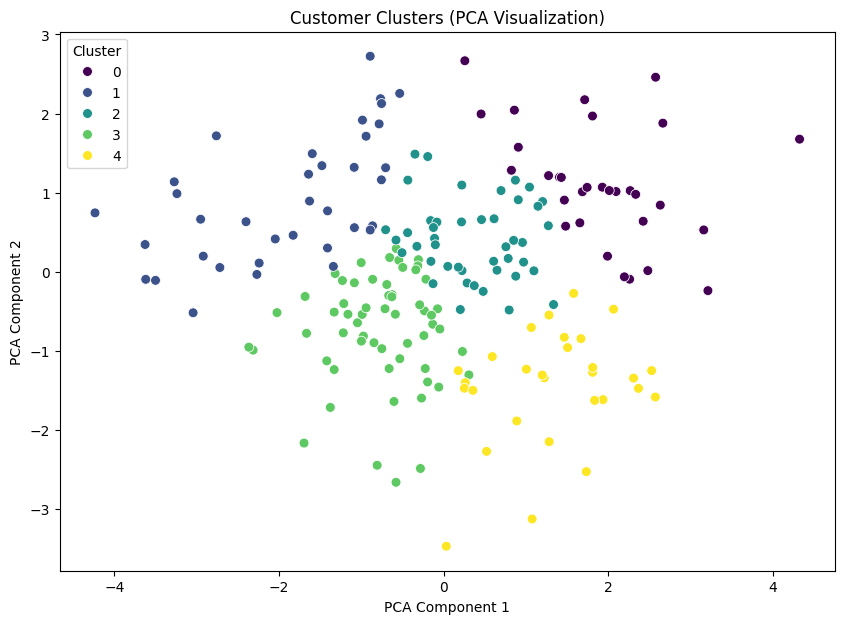

Clustering completed. Results saved to 'Customer_Clusters.csv'.


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
transactions = transactions.merge(customers, on='CustomerID', how='left')

# Feature engineering: Aggregate customer-level data
customer_features = transactions.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    AvgTransactionValue=('TotalValue', 'mean'),
    TotalTransactions=('TransactionID', 'count'),
    AvgQuantity=('Quantity', 'mean'),
    Region=('Region', 'first')  # Keep region for encoding
).reset_index()

# Encode categorical features (Region) using OneHotEncoder
region_encoded = pd.get_dummies(customer_features['Region'], prefix='Region')
customer_features = pd.concat([customer_features, region_encoded], axis=1)
customer_features.drop('Region', axis=1, inplace=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['TotalSpending', 'AvgTransactionValue', 'TotalTransactions', 'AvgQuantity']
customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])

# Apply KMeans clustering
n_clusters = 5  # Choose number of clusters (2-10)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features.drop(columns=['CustomerID']))

# Calculate Davies-Bouldin Index and Silhouette Score
db_index = davies_bouldin_score(customer_features.drop(columns=['CustomerID', 'Cluster']), customer_features['Cluster'])
silhouette_avg = silhouette_score(customer_features.drop(columns=['CustomerID', 'Cluster']), customer_features['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_features.drop(columns=['CustomerID', 'Cluster']))
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Save clustering results
customer_features.to_csv('Customer_Clusters.csv', index=False)

print("Clustering completed. Results saved to 'Customer_Clusters.csv'.")
